## From the article

# Implementing a distance-based classifier with a quantum interference circuit

###  M. Schuld et al 2017 EPL 119 60002

## Let's input all the features of the Iris Data Set

# Preparing the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv("Iris/iris.data",header=None,names=["f0","f1","f2","f3","class"])

In [4]:
setosa = iris[iris["class"] == "Iris-setosa"]
# setosa.loc[:,"class"] = -1
setosa.loc[:,"color"] = "DarkGreen"

In [5]:
versicolor = iris[iris["class"] == "Iris-versicolor"]
# versicolor.loc[:,"class"] = 1
versicolor.loc[:,"color"] = "DarkBlue"

In [6]:
virginica = iris[iris["class"] == "Iris-virginica"]
# virginica.loc[:,"class"] = 1
virginica.loc[:,"color"] = "DarkRed"

In [ ]:
data = pd.concat([setosa,versicolor])

In [7]:
data = pd.concat([versicolor,virginica])

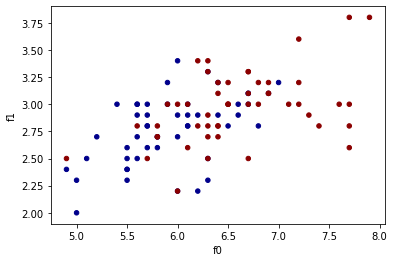

In [9]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [10]:
data.loc[:,["f0","f1","f2","f3"]].describe()

,f0,f1,f2,f3
count,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000
std,0.662834,0.332751,0.825578,0.424769
min,4.900000,2.000000,3.000000,1.000000
25%,5.800000,2.700000,4.375000,1.300000
50%,6.300000,2.900000,4.900000,1.600000
75%,6.700000,3.025000,5.525000,2.000000
max,7.900000,3.800000,6.900000,2.500000


In [ ]:
# data.mean()
# data["f0"] -= data.mean()[0]
# data["f1"] -= data.mean()[1]

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.loc[:,["f0","f1","f2","f3"]] = scaler.fit_transform(data.loc[:,["f0","f1","f2","f3"]])

In [12]:
data.loc[:,["f0","f1","f2","f3"]].describe()

,f0,f1,f2,f3
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-6.683543e-16,1.624256e-15,3.269607e-16,-1.443845e-15
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-2.065164e+00,-2.633780e+00,-2.320315e+00,-1.599473e+00
25%,-7.005180e-01,-5.195071e-01,-6.464256e-01,-8.896475e-01
50%,5.761837e-02,8.457092e-02,-7.304244e-03,-1.798224e-01
75%,6.641275e-01,4.621197e-01,7.535546e-01,7.666111e-01
max,2.483655e+00,2.802922e+00,2.427444e+00,1.949653e+00


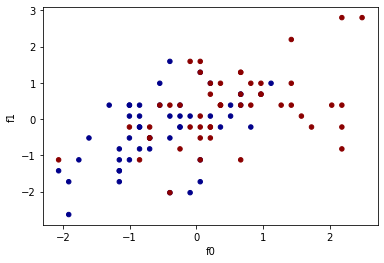

In [13]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [14]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [15]:
for i in data.index:
    v = [data["f0"][i],data["f1"][i],data["f2"][i],data["f3"][i]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"], data.loc[i,"f2"], data.loc[i,"f3"] = v[0], v[1], v[2], v[3]

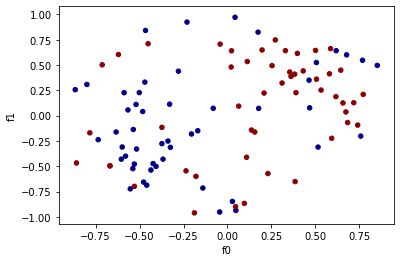

In [16]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [ ]:
# For setosa and versicolor
vectors = data.loc[[33,85,28,36],["f0","f1","f2","f3","class"]]
vectors["label"] = ["t0","t1","x0","x1"]
vectors

In [17]:
# For versicolor and virginica
vectors = data.loc[[50,145,53,149],["f0","f1","f2","f3","class"]]
vectors["label"] = ["t0","t1","x0","x1"]
vectors

,f0,f1,f2,f3,class,label
50,0.678126,0.600362,-0.151974,-0.395745,Iris-versicolor,t0
145,0.390090,0.227084,0.210225,0.867218,Iris-virginica,t1
53,-0.459313,-0.686808,-0.438459,-0.353667,Iris-versicolor,x0
149,-0.713022,0.502216,0.306791,0.381126,Iris-virginica,x1


In [18]:
vectors.iloc[:,0:4].apply(np.arcsin)

,f0,f1,f2,f3
50,0.745210,0.643954,-0.152565,-0.406879
145,0.400730,0.229083,0.211805,1.049588
53,-0.477222,-0.757088,-0.453883,-0.361488
149,-0.793800,0.526159,0.311820,0.391014


In [19]:
t0 = vectors.iloc[0:1,0:4].apply(np.arcsin).to_numpy()[0]

In [20]:
t1 = vectors.iloc[1:2,0:4].apply(np.arcsin).to_numpy()[0]

In [21]:
x0 = vectors.iloc[2:3,0:4].apply(np.arcsin).to_numpy()[0]

In [22]:
x1 = vectors.iloc[3:4,0:4].apply(np.arcsin).to_numpy()[0]

# Building the quantum circuit

To store 4 features I need 2 $i$ qubits.  
I need some ancilla qubits for the QRAM routine.  
I need one more bit to store the conditional measurement on the rotation qubit. 

In [23]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
import qiskit.aqua.circuits.gates.controlled_ry_gates

In [24]:
a = QuantumRegister(1,'a')
m = QuantumRegister(1,'m')
i = QuantumRegister(2,'i')
r = QuantumRegister(1,'r')
q = QuantumRegister(3,'q')
c = QuantumRegister(1,'c')
b = ClassicalRegister(3, 'bit')
circuit = QuantumCircuit(a,m,i,r,q,c,b)

circuit.h(a)
circuit.h(m)
circuit.h(i)
circuit.h(c)

circuit.barrier()

# circuit.cry(theta, control, target)
# circuit.mcry(theta, controls, target, ancillae)

# >>> Encode the input vector >>>

# |00>
circuit.x(i)
circuit.mcry(x0[0],a[:]+i[:],r[0],q)
circuit.x(i)

# |01>
circuit.x(i[1])
circuit.mcry(x0[1],a[:]+i[:],r[0],q)
circuit.x(i[1])

# |10>
circuit.x(i[0])
circuit.mcry(x0[2],a[:]+i[:],r[0],q)
circuit.x(i[0])

# |11>
circuit.mcry(x0[3],a[:]+i[:],r[0],q)

circuit.x(a)

# <<< Encode the input vector <<<

circuit.barrier()

# >>> Encode the first training vector >>>

circuit.x(c)
circuit.x(m)

# |00>
circuit.x(i)
circuit.mcry(t0[0],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i)

# |01>
circuit.x(i[1])
circuit.mcry(t0[1],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[1])

# |10>
circuit.x(i[0])
circuit.mcry(t0[2],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[0])

# |11>
circuit.mcry(t0[3],a[:]+i[:]+m[:]+c[:],r[0],q)

circuit.x(c)
circuit.x(m)

# <<< Encode the first training vector <<<

circuit.barrier()

# >>> Encode the second training vector >>>

# |00>
circuit.x(i)
circuit.mcry(t1[0],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i)

# |01>
circuit.x(i[1])
circuit.mcry(t1[1],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[1])

# |10>
circuit.x(i[0])
circuit.mcry(t1[2],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[0])

# |11>
circuit.mcry(t1[3],a[:]+i[:]+m[:]+c[:],r[0],q)

# <<< Encode the second training vector <<<

circuit.barrier()

# circuit.ccx(a,m,i)
# circuit.x(m)

# circuit.barrier()

# circuit.mcry(t1,a[:]+m[:],i[0],None)

# circuit.barrier()

# circuit.cx(m,c) Questo potrebbe essere una cosa che ho dimenticato

# circuit.barrier()

circuit.measure(r,b[0])

circuit.h(a)

circuit.measure(a,b[1])
circuit.measure(c,b[2])

# circuit.draw(output='mpl')


Total counts are: {'100': 3948, '101': 57, '011': 126, '110': 6, '001': 75, '010': 2, '000': 3807, '111': 171}


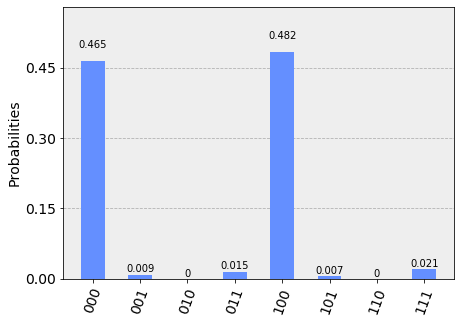

In [25]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=8192)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
plot_histogram(counts)

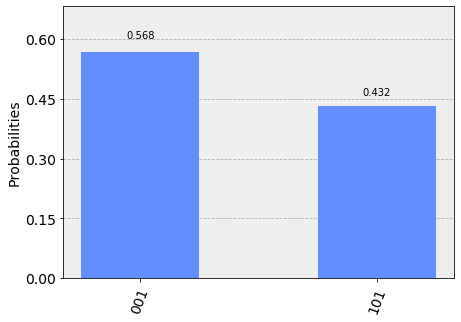

In [26]:
goodCounts = {k: counts[k] for k in counts.keys() & {'001', '101'}}
plot_histogram(goodCounts)